In [22]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll, predict_f
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton
from numpy.linalg import multi_dot

In [205]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.01

ntrain = 20
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
np.random.seed(0)
ytrain = ftrain + noise_train*np.random.randn(ntrain, 1)

In [220]:
# GP regression with fixed kernel hyperparameters
hyp = [0.5, 1e-6]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 50
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean


[[-0.10145647]
 [-0.02391814]
 [ 0.03402028]
 [ 0.07200972]
 [ 0.09047954]
 [ 0.09059373]
 [ 0.07418535]
 [ 0.04367113]
 [ 0.00194859]
 [-0.04772109]
 [-0.10184111]
 [-0.15681409]
 [-0.20907978]
 [-0.25525136]
 [-0.29224578]
 [-0.317404  ]
 [-0.32859717]
 [-0.32431496]
 [-0.30373307]
 [-0.26675729]
 [-0.2140421 ]
 [-0.14698288]
 [-0.06768123]
 [ 0.02111611]
 [ 0.11610347]
 [ 0.21352542]
 [ 0.30930625]
 [ 0.39919616]
 [ 0.47893018]
 [ 0.54439518]
 [ 0.59180035]
 [ 0.61784581]
 [ 0.6198845 ]
 [ 0.59607221]
 [ 0.54550105]
 [ 0.46831196]
 [ 0.36578242]
 [ 0.24038612]
 [ 0.09582214]
 [-0.06298811]
 [-0.22993704]
 [-0.39779996]
 [-0.5583363 ]
 [-0.70242097]
 [-0.82020343]
 [-0.90129096]
 [-0.93495205]
 [-0.91033544]
 [-0.81669964]
 [-0.64364771]]


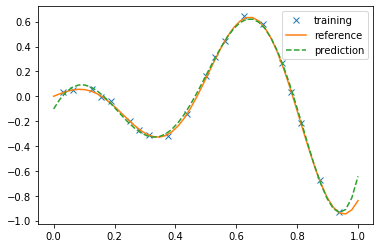

In [207]:
plt.figure()
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

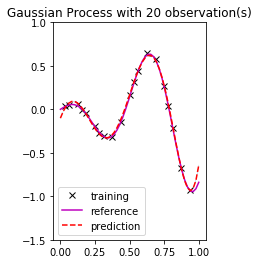

In [208]:
Ef, varf = predict_f(hyp, xtrain.reshape(-1, 1),
                      ytrain.reshape(-1, 1), xtest.reshape(-1, 1), neig=8)# posterior Estimation and variance
varf = np.diag(varf)

# we keep only the diag because the variance is on it, the other terms are covariance

plt.subplot(1, 2, 1)
plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-1.5, 1])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(varf)), # y1
                 (fmean.flatten() - 2 * np.sqrt(varf))) # y2

In [210]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 3, 50)
nlls = np.array(
    [nll([l, 0.00694534], xtrain, ytrain, 0) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

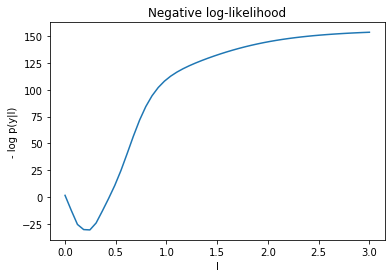

In [212]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')

In [214]:
from scipy.optimize import minimize

def nll_transform(log10hyp):
    hyp = 10**log10hyp
    return nll(hyp, xtrain, ytrain, 0)

res = minimize(nll_transform, np.array([0, -6]), method='BFGS')

In [215]:
print(res)
print('[l,sig2] = ', 10**res.x)

      fun: -51.35427379159095
 hess_inv: array([[0.00129113, 0.00049261],
       [0.00049261, 0.03422863]])
      jac: array([3.95774841e-05, 1.57356262e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 268
      nit: 19
     njev: 65
   status: 2
  success: False
        x: array([-0.64803431, -4.02323524])
[l,sig2] =  [2.24887695e-01 9.47904880e-05]


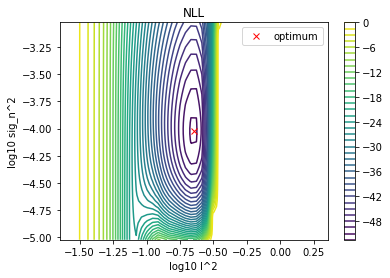

In [217]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)
log10s2 = np.linspace(res.x[1]-1, res.x[1]+1, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2 for ll in log10l]
    ).reshape([ns2, nl])

# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')
plt.contour(Ll, Ls2, nlls, levels=50)
plt.plot(res.x[0], res.x[1], 'rx')
plt.xlabel('log10 l^2')
plt.ylabel('log10 sig_n^2')
plt.colorbar()
plt.legend(['optimum'])
plt.show()

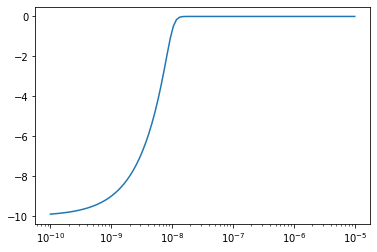

In [199]:
# Trying out priors to cut values

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def prior(hyp):
    return sigmoid(hyp[0]-6)*sigmoid(hyp[-1]-6)

x = np.logspace(-10, -5, 100)
plt.semilogx(x, np.log(sigmoid(1e9*x - 10)))

In [218]:

from profit.sur.backend.gp_functions import k

def dkdl(xa, xb, l): # derivative of the kernel w.r.t lengthscale
    return (xa - xb)**2.0 * np.exp(-(xa-xb)**2.0/(2 * l**2)) / l**3


K = k(xtrain, xtrain, hyp[0])


K_star = k(xtest, xtrain, hyp[0])


K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K_prime[i, j] = dkdl(xtrain[i], xtrain[i], hyp[0])


K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star_prime[i, j] = dkdl(xtest[i], xtrain[j], hyp[0])


print("K.shape ", K.shape)
print("K_prime.shape ", K_prime.shape)

print("\nK_star.shape ", K_star.shape)
print("K_star_prime.shape ", K_star_prime.shape)

K.shape  (20, 1)
K_prime.shape  (20, 20)

K_star.shape  (20, 50)
K_star_prime.shape  (50, 20)


In [219]:

alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

dalpha_dl = -Kyinv.dot(K_prime)\
    .dot(Kyinv)\
    .dot(ytrain)

dalpha_ds = Kyinv.dot(np.eye(ntrain)).dot(Kyinv).dot(ytrain) # Kyinv x I x Kyinv x ytrain 


print("xtest.shape ", xtest.shape)
print("xtrain.shape ", xtrain.shape)
print("ytrain.shape ", ytrain.shape)
print("\nKyinv.shape ", Kyinv.shape)
print("K_prime.shape ", K_prime.shape)
print("K_star_prime.shape ", K_star_prime.shape)
print("K.shape ", K.shape)
print("\nalpha.shape ", alpha.shape)
print("dalpha_ds.shape ", dalpha_ds.shape)
print("dalpha_dl.shape ", dalpha_dl.shape)

# 
# dm_dl = np.dot(K_prime, alpha) - np.dot(K, dalpha_dl)  # It used to be dot(alpha, K_prime) 
#                                                       # but it's more revelant to use dot(K_prime, alpha)
#                                                                                                          
# dm_ds = np.dot(-K, dalpha_ds)  

# print("\ndm_dl.shape ", dm_dl.shape)
# print("dm_ds.shape ", dm_ds.shape)

dm = np.empty((ntest,len(hyp), 1))

for nb_hyp in range(len(hyp)):
    if nb_hyp == 0 :
        dm[:,nb_hyp,:] = np.dot(K_star_prime, alpha) -\
                         np.dot(K_star.T, dalpha_dl)
    else : 
        dm[:,nb_hyp,:] = np.dot(-K_star.T, dalpha_ds)

print("dm.shape ", dm.shape)
        
    




xtest.shape  (50,)
xtrain.shape  (20, 1)
ytrain.shape  (20, 1)

Kyinv.shape  (20, 20)
K_prime.shape  (20, 20)
K_star_prime.shape  (50, 20)
K.shape  (20, 1)

alpha.shape  (20, 1)
dalpha_ds.shape  (20, 1)
dalpha_dl.shape  (20, 1)
dm.shape  (50, 2, 1)


In [202]:
sigma = invert(res.hess_inv) # define the sigma matrix as the inverse of hess_inv
V = varf # set V as the result of the predict_f diagonal  

print("\nsigma shape : ", sigma.shape)
print("dm.shape : ", dm.shape)



dm_transpose = np.empty((ntest, 1, len(hyp)))
test = np.empty((ntest, 1, len(hyp)))
final = np.empty((ntest, 1))

for i in range(ntest):
    dm_transpose[i] = dm[i].T
    test[i] = dm_transpose[i].dot(sigma)
    final[i] = test[i].dot(dm[i])
    
print("dm_transpose.shape :", dm_transpose.shape)
print("\ntest.shape ", test.shape)
print("final.shape ", final.shape)
print("V.shape ", V.shape)


 
V_tild = V.reshape((ntest,1)) + final # Osborne et al. (2012) Active learning eq.19 


print("V_tild.shape ", V_tild.shape)
print("\n\n\tMarginal variance\n\n", V_tild)





sigma shape :  (2, 2)
dm.shape :  (20, 2, 1)
dm_transpose.shape : (20, 1, 2)

test.shape  (20, 1, 2)
final.shape  (20, 1)
V.shape  (20,)
V_tild.shape  (20, 1)


	Marginal variance

 [[2.75589774e+14]
 [9.56234924e+12]
 [1.87405433e+13]
 [3.61649398e+10]
 [1.24526514e+13]
 [1.21476415e+13]
 [8.58381539e+11]
 [4.11758184e+12]
 [1.24140522e+13]
 [8.11073315e+12]
 [3.59456431e+11]
 [3.22656709e+12]
 [8.46169610e+12]
 [4.41095724e+12]
 [3.99113185e+09]
 [4.09931928e+12]
 [4.54693153e+12]
 [3.21596620e+09]
 [2.57265480e+12]
 [1.62773361e+13]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)
